# Find Pairs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import seaborn as sns
from pathlib import Path
from varname import nameof
import re

plt.style.use("seaborn-v0_8-white")

In [112]:
df = pd.concat([pd.read_pickle(f"data/ts/pkls/europa_ROIs2017_146_{patch}.pkl") for patch in range(30)]).reset_index(drop=True)
df['continent'] = "europa"
display(df.shape)
df.head(3)

(9000, 211)

0_traditional_contrast  0_michelson_contrast  0_rms_contrast  \
0                0.454809                   1.0       61.043858   
1                0.529204                   1.0       59.268642   
2                0.662275                   1.0       75.088112   

   0_laplacian_blur      0_mean  0_median  0_p25  0_p75      0_std  \
0        253.599681  134.218811     132.0   91.0  180.0  61.043858   
1        234.429785  111.995728     114.0   71.0  147.0  59.268642   
2        151.575154  113.379059     119.0   45.0  176.0  75.088112   

   1_traditional_contrast  ...  ndsi_under25  ndsi_p75  ndsi_over75       roi  \
0                0.474263  ...       16383.0  2.031579      16382.0  ROIs2017   
1                0.495702  ...       16381.0  2.000000      16382.0  ROIs2017   
2                0.716577  ...       16383.0  2.035088      16382.0  ROIs2017   

   season  patch  scene  time_interval       time  continent  
0  winter    191    146              0 2018-01-06     europa  
1  winter    146    146              0 2018-01-06     europa  
2  winter    261    146              0 2018-01-06     europa  

[3 rows x 211 columns]

In [113]:
def add_continent(pkl):
    df = pd.read_pickle(pkl)
    continent = pkl.name.split('_')[0]
    df['continent'] = continent
    return df

all_df = pd.concat([add_continent(pkl) for pkl in Path("data/ts/pkls").iterdir()]).reset_index(drop=True)

In [114]:
ROI = "ROIs2017"
SCENE = 146
PATCH = 0
CONTINENT = "europa"
KEY_FEATS = [nameof(ROI), nameof(SCENE), nameof(PATCH), nameof(CONTINENT)]

In [118]:
def get_patch_df(df, patch: int):
    patch_df = df[df['patch'] == patch]
    return patch_df.sort_values('time_interval').reset_index(drop=True)

patch_df = get_patch_df(df, 0)

## Show samples

In [117]:
def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0.1, 255)).astype(np.uint8)


def sigmoid(x):
    return 255 / (1 + np.exp(-2 * (scaled(x) / 255 - 0.5)))


def get_tci(img):
    r = sigmoid(img.read(4))
    g = sigmoid(img.read(3))
    b = sigmoid(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

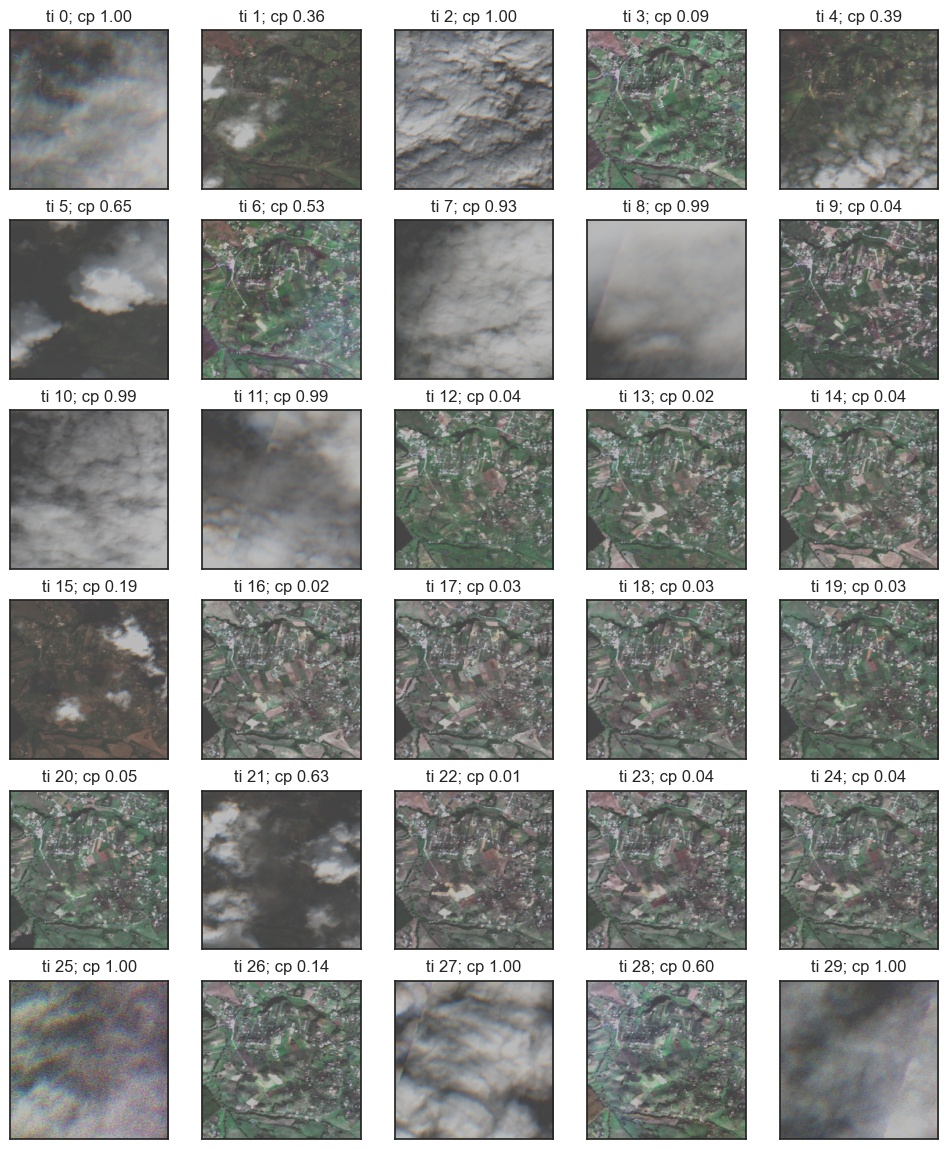

In [119]:
fig, axs = plt.subplots(6, 5, figsize=(12, 12 / 5 * 6))
axs = axs.reshape(-1)
for sample_img in Path('data/ts/sample_imgs/').iterdir():
    result = re.match(r"s2_(?P<roi>ROIs\d\d\d\d)_(?P<scene>\d+)_ImgNo_(?P<time_interval>\d+)_\d+-\d+-\d+_patch_(?P<patch>\d+)", sample_img.name)
    roi, scene, time_interval, patch = result.groups()
    axs[int(time_interval)].imshow(get_tci(rio.open(sample_img)))
    axs[int(time_interval)].get_xaxis().set_visible(False)
    axs[int(time_interval)].get_yaxis().set_visible(False)
    cp = patch_df[patch_df.time_interval == int(time_interval)].iloc[0]['cloud_percentage']
    axs[int(time_interval)].set_title("ti {}; cp {:.2f}".format(time_interval, cp))

## Band and Index Exploration 

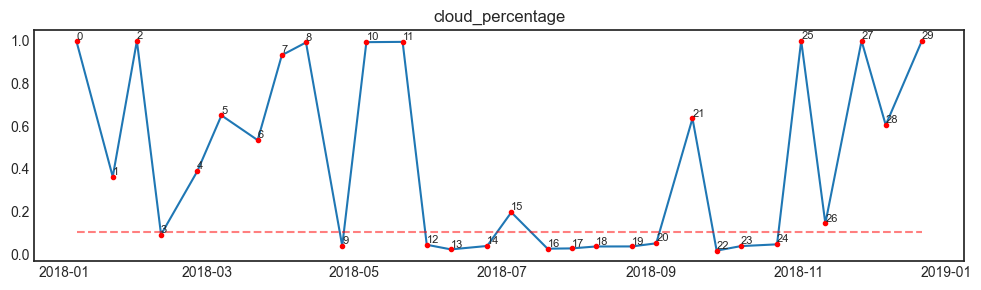

In [125]:
def show_feat_interval(df, feat, limit=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.plot(df['time'], df[feat])
    ax.plot(df['time'], df[feat], 'ro', markersize=3)
    for i, row in df.iterrows():
        ax.text(row['time'], row[feat] + 0.01, row['time_interval'], fontsize=8)
    if limit:
        ax.plot(df['time'].iloc[[0, -1]], [limit, limit], '--r', alpha=0.5)
    ax.set_title(feat)

fig, ax = plt.subplots(1,1, figsize=(12, 3))
show_feat_interval(patch_df, 'cloud_percentage', limit=0.1, ax=ax)

### Show bands

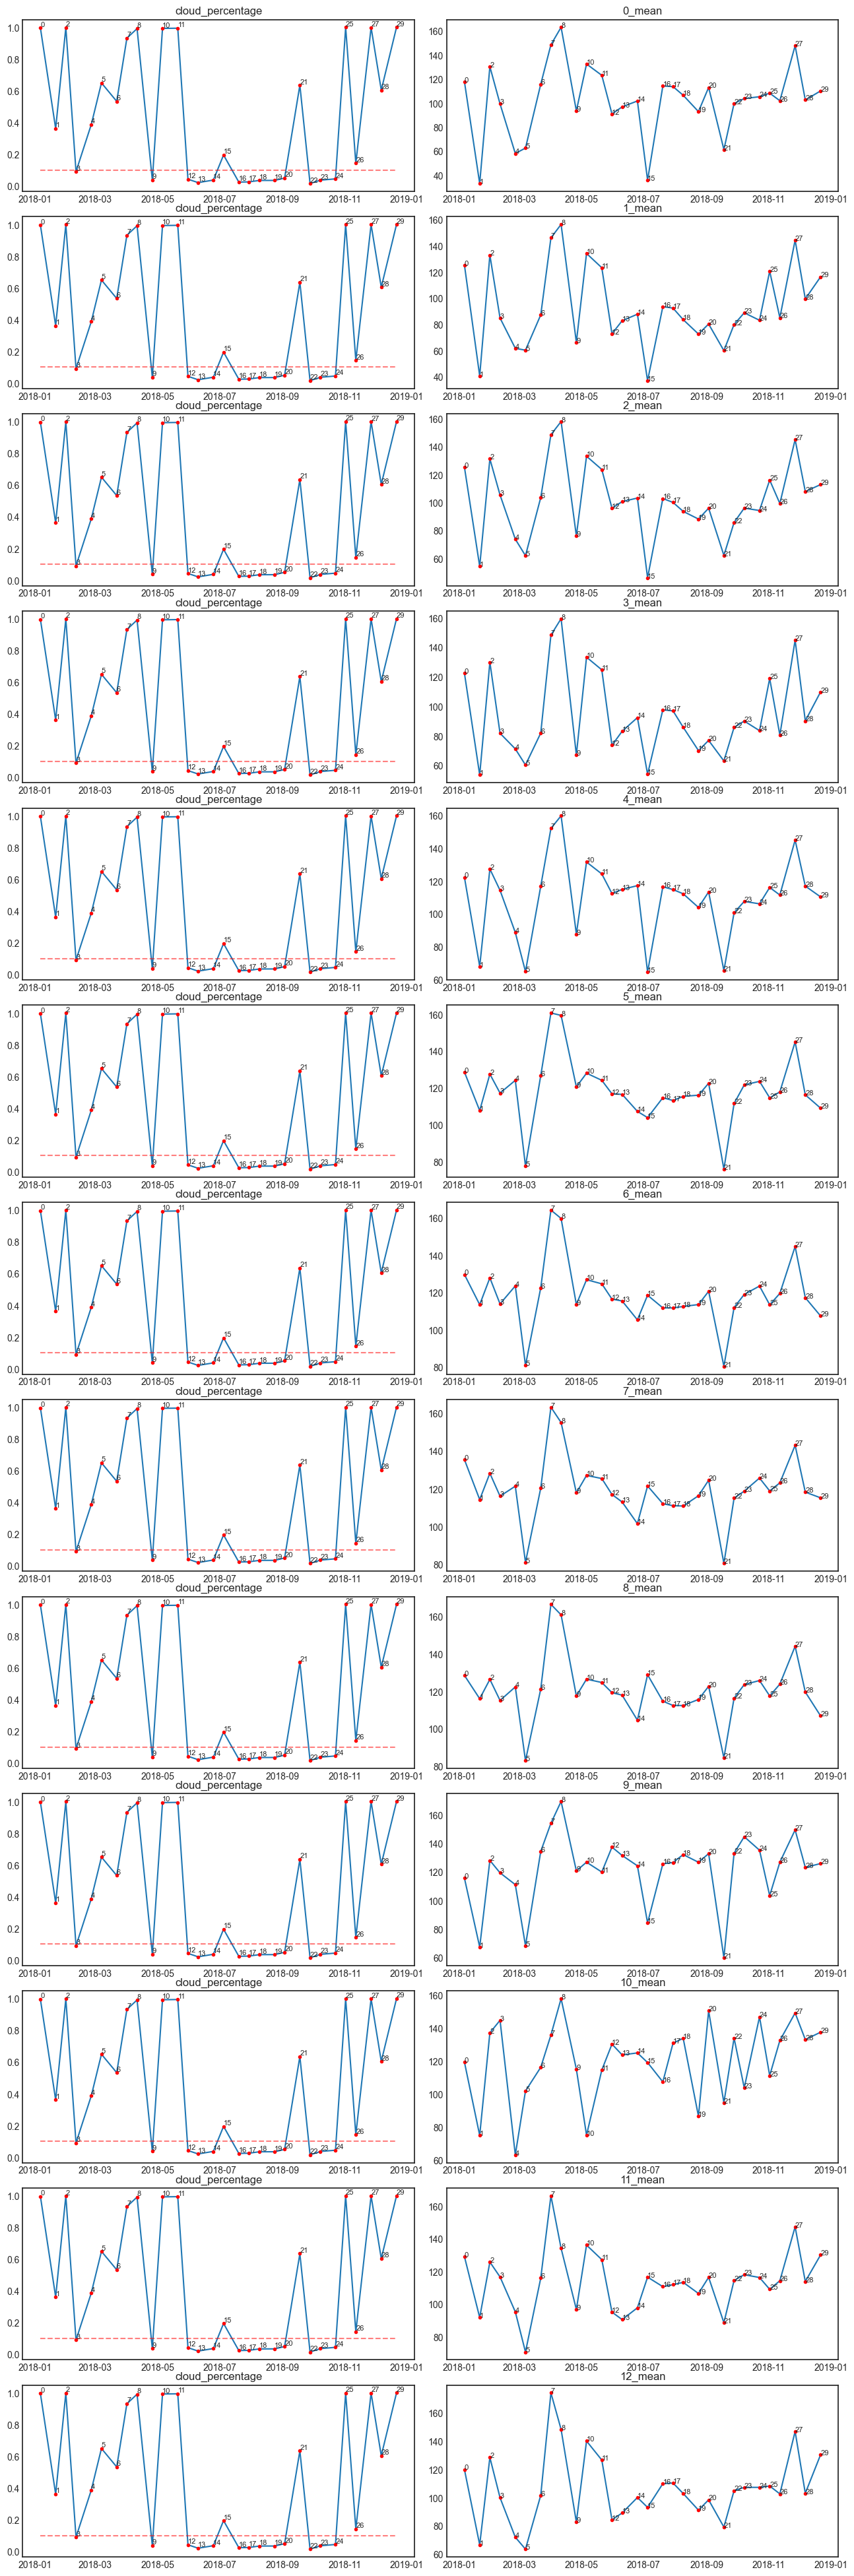

In [121]:
BAND_FEATS = [f"{i}_mean" for i in range(13)]
fig, axs = plt.subplots(13, 2, figsize=(13, 3*13))
fig.tight_layout(h_pad=1)
for index, (c_ax, f_ax) in zip(BAND_FEATS, axs):
    show_feat_interval(patch_df, 'cloud_percentage', limit=0.1, ax=c_ax)
    show_feat_interval(patch_df, index, ax=f_ax)

### Show indexs

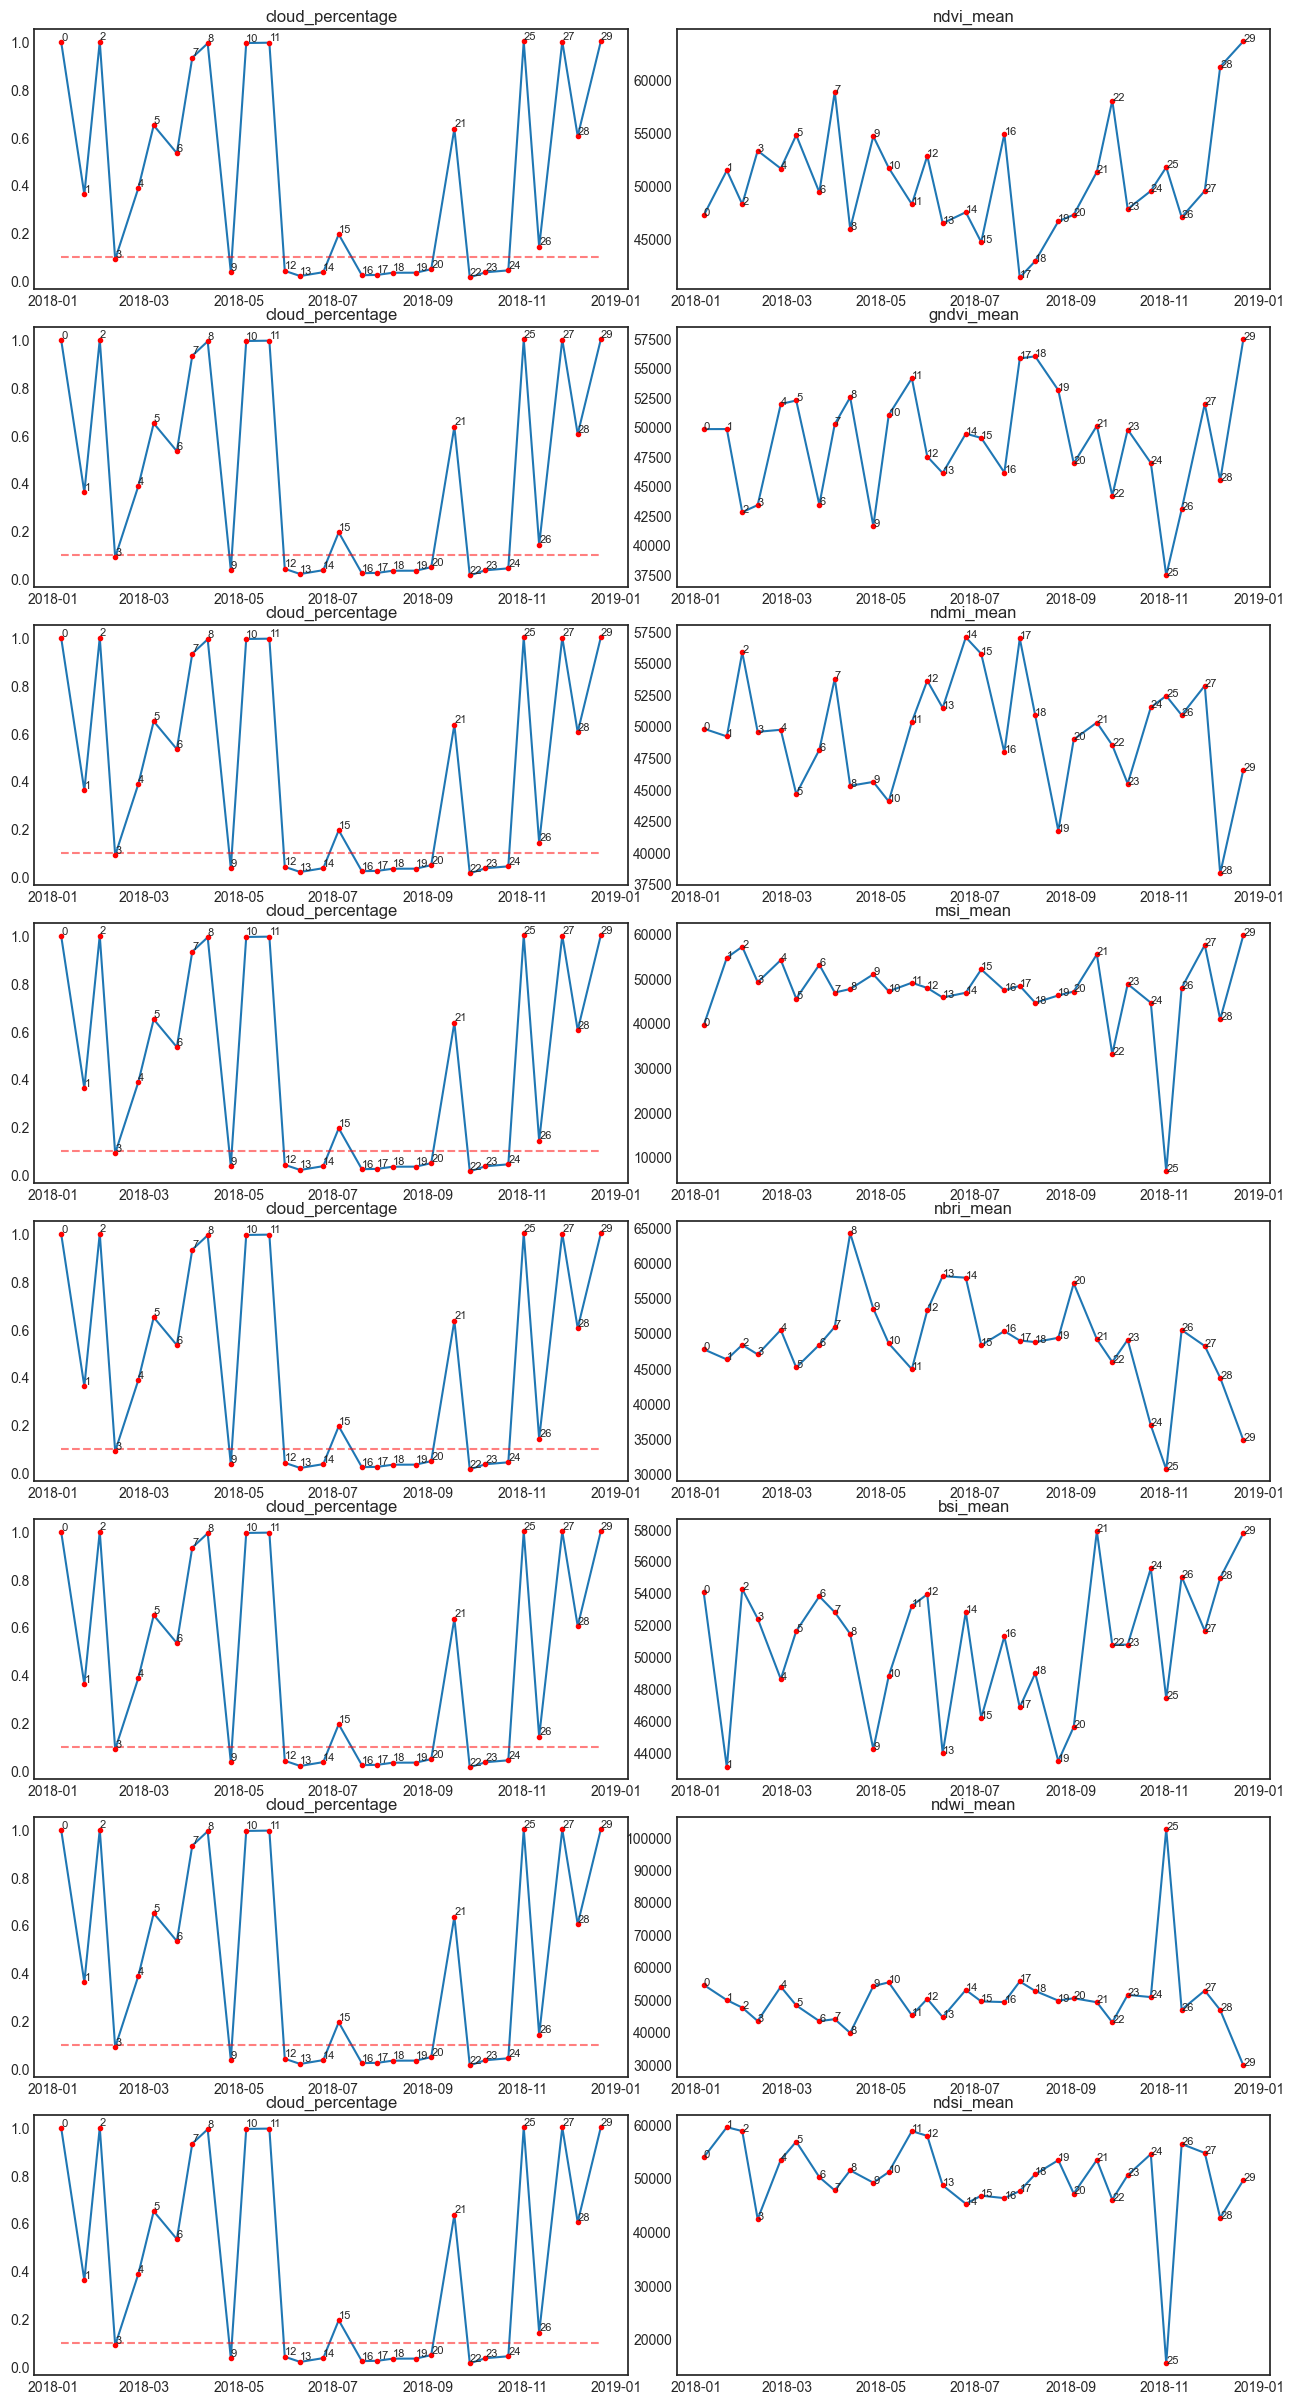

In [126]:
INDEXS = ["ndvi", "gndvi", "ndmi", "msi", "nbri", "bsi", "ndwi", "ndsi"]
INDEX_FEATS = [f"{index}_mean" for index in INDEXS]
fig, axs = plt.subplots(len(INDEXS), 2, figsize=(13, 3*len(INDEXS)))
fig.tight_layout(h_pad=1)
for index, (c_ax, f_ax) in zip(INDEX_FEATS, axs):
    show_feat_interval(patch_df, 'cloud_percentage', limit=0.1, ax=c_ax)
    show_feat_interval(patch_df, index, ax=f_ax)

### Outlier detection

- IQR
- Standard deviation
- Z-score

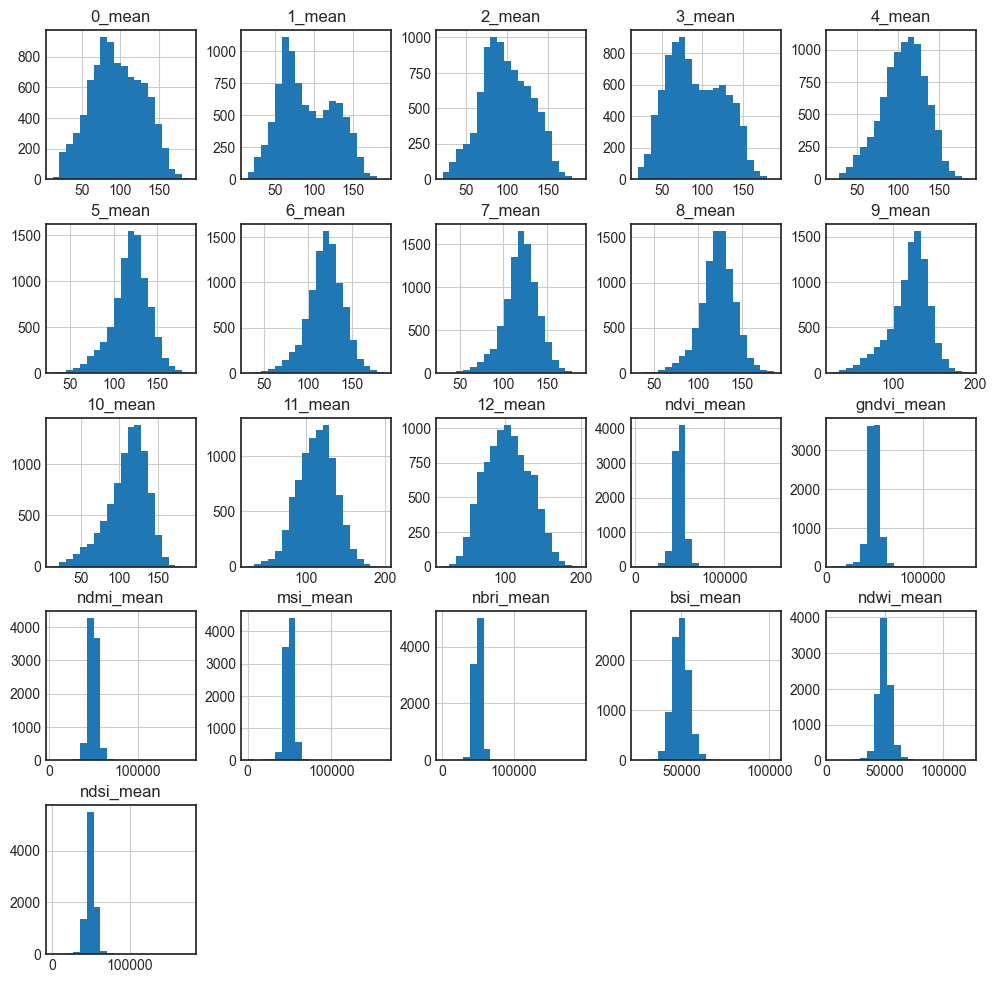

In [127]:
OUTLIER_FEATS = BAND_FEATS + INDEX_FEATS
df[OUTLIER_FEATS].hist(bins=20, figsize=(12, 12))
pass

In [128]:
def show_outlier_properties(outliers, feats=('patch', 'time_interval')):
    """
    This function will show the outlier df distribution
    """
    fig, axs = plt.subplots(len(feats),1, figsize=(16, 3))
    fig.tight_layout(h_pad=2)
    for feat_plot, row_ax in zip(feats, axs):
        value_counts = outliers[feat_plot].value_counts()
        if feat_plot == 'time_interval':
            value_counts = value_counts.sort_index()
        value_counts.plot(kind='bar', ax=row_ax)
        row_ax.set_title(feat_plot)

#### IQR

33 outliers


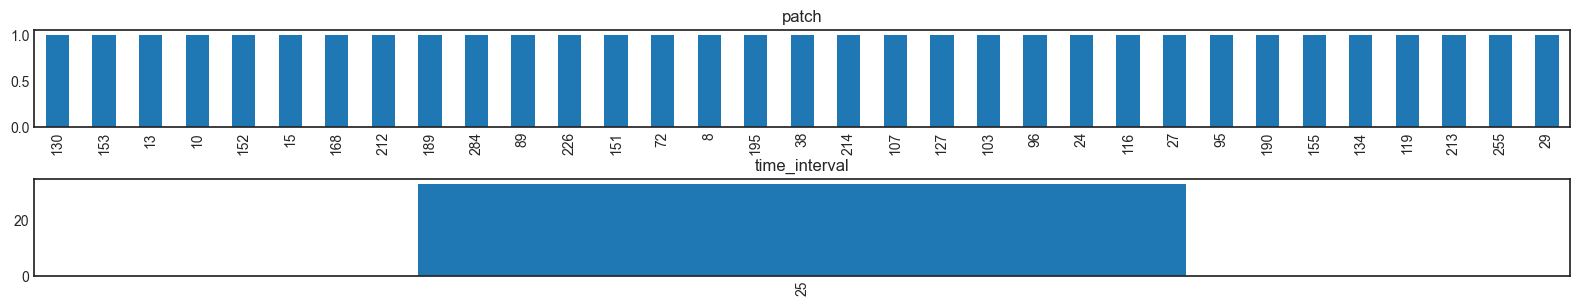

In [129]:
def iqr_outlier_detection(df):
    q1 = df[INDEX_FEATS].quantile(0.25)
    q3 = df[INDEX_FEATS].quantile(0.75)
    iqr = q3 - q1
    outliers = (df[((df[INDEX_FEATS] < (q1 - 1.5 * iqr)).sum(axis=1) > len(INDEX_FEATS) // 2) & ((df[INDEX_FEATS] < (q3 + 1.5 * iqr)).sum(axis=1) > len(INDEX_FEATS) // 2)])
    return outliers
    
iqr_outliers = iqr_outlier_detection(df)
print(iqr_outliers.shape[0], "outliers")
show_outlier_properties(iqr_outliers)

In [130]:
iqr_outlier_detection(patch_df)

Empty DataFrame
Columns: [0_traditional_contrast, 0_michelson_contrast, 0_rms_contrast, 0_laplacian_blur, 0_mean, 0_median, 0_p25, 0_p75, 0_std, 1_traditional_contrast, 1_michelson_contrast, 1_rms_contrast, 1_laplacian_blur, 1_mean, 1_median, 1_p25, 1_p75, 1_std, 2_traditional_contrast, 2_michelson_contrast, 2_rms_contrast, 2_laplacian_blur, 2_mean, 2_median, 2_p25, 2_p75, 2_std, 3_traditional_contrast, 3_michelson_contrast, 3_rms_contrast, 3_laplacian_blur, 3_mean, 3_median, 3_p25, 3_p75, 3_std, 4_traditional_contrast, 4_michelson_contrast, 4_rms_contrast, 4_laplacian_blur, 4_mean, 4_median, 4_p25, 4_p75, 4_std, 5_traditional_contrast, 5_michelson_contrast, 5_rms_contrast, 5_laplacian_blur, 5_mean, 5_median, 5_p25, 5_p75, 5_std, 6_traditional_contrast, 6_michelson_contrast, 6_rms_contrast, 6_laplacian_blur, 6_mean, 6_median, 6_p25, 6_p75, 6_std, 7_traditional_contrast, 7_michelson_contrast, 7_rms_contrast, 7_laplacian_blur, 7_mean, 7_median, 7_p25, 7_p75, 7_std, 8_traditional_contrast, 8_michelson_contrast, 8_rms_contrast, 8_laplacian_blur, 8_mean, 8_median, 8_p25, 8_p75, 8_std, 9_traditional_contrast, 9_michelson_contrast, 9_rms_contrast, 9_laplacian_blur, 9_mean, 9_median, 9_p25, 9_p75, 9_std, 10_traditional_contrast, 10_michelson_contrast, 10_rms_contrast, 10_laplacian_blur, 10_mean, 10_median, 10_p25, 10_p75, 10_std, 11_traditional_contrast, ...]
Index: []

[0 rows x 211 columns]

#### STD Deviation

In [131]:
def std_deviation_outlier_detection(df):
    mean = df[INDEX_FEATS].mean()
    std = df[INDEX_FEATS].std()
    outliers = (df[((df[INDEX_FEATS] < (mean - 3 * std)).sum(axis=1) > len(INDEX_FEATS) // 2) & ((df[INDEX_FEATS] < (mean + 3 * std)).sum(axis=1) > len(INDEX_FEATS) // 2)])
    return outliers
    
std_deviation_outlier_detection(patch_df)

Empty DataFrame
Columns: [0_traditional_contrast, 0_michelson_contrast, 0_rms_contrast, 0_laplacian_blur, 0_mean, 0_median, 0_p25, 0_p75, 0_std, 1_traditional_contrast, 1_michelson_contrast, 1_rms_contrast, 1_laplacian_blur, 1_mean, 1_median, 1_p25, 1_p75, 1_std, 2_traditional_contrast, 2_michelson_contrast, 2_rms_contrast, 2_laplacian_blur, 2_mean, 2_median, 2_p25, 2_p75, 2_std, 3_traditional_contrast, 3_michelson_contrast, 3_rms_contrast, 3_laplacian_blur, 3_mean, 3_median, 3_p25, 3_p75, 3_std, 4_traditional_contrast, 4_michelson_contrast, 4_rms_contrast, 4_laplacian_blur, 4_mean, 4_median, 4_p25, 4_p75, 4_std, 5_traditional_contrast, 5_michelson_contrast, 5_rms_contrast, 5_laplacian_blur, 5_mean, 5_median, 5_p25, 5_p75, 5_std, 6_traditional_contrast, 6_michelson_contrast, 6_rms_contrast, 6_laplacian_blur, 6_mean, 6_median, 6_p25, 6_p75, 6_std, 7_traditional_contrast, 7_michelson_contrast, 7_rms_contrast, 7_laplacian_blur, 7_mean, 7_median, 7_p25, 7_p75, 7_std, 8_traditional_contrast, 8_michelson_contrast, 8_rms_contrast, 8_laplacian_blur, 8_mean, 8_median, 8_p25, 8_p75, 8_std, 9_traditional_contrast, 9_michelson_contrast, 9_rms_contrast, 9_laplacian_blur, 9_mean, 9_median, 9_p25, 9_p75, 9_std, 10_traditional_contrast, 10_michelson_contrast, 10_rms_contrast, 10_laplacian_blur, 10_mean, 10_median, 10_p25, 10_p75, 10_std, 11_traditional_contrast, ...]
Index: []

[0 rows x 211 columns]

#### Z-score 

33 outliers


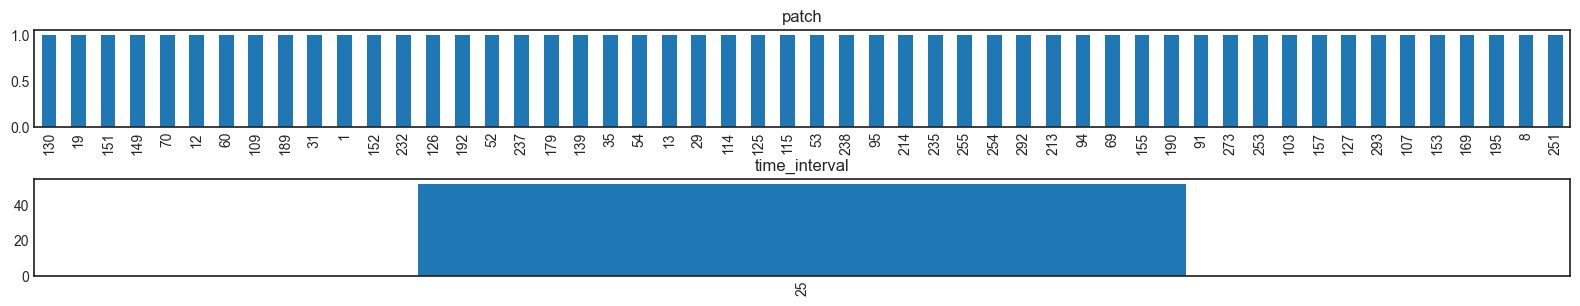

In [132]:
def z_score_outlier_detection(df):
    mean = df[INDEX_FEATS].mean()
    std = df[INDEX_FEATS].std()
    z_score = ((df[INDEX_FEATS] - mean) / std).abs()
    outliers = df[((z_score > 3).sum(axis=1) > len(INDEX_FEATS) // 2)]
    return outliers

z_score_outliers = z_score_outlier_detection(df)
print(iqr_outliers.shape[0], "outliers")
show_outlier_properties(z_score_outliers)

In [133]:
# How would be with any outlier from any feat?
df[(((df[INDEX_FEATS] - df[INDEX_FEATS].mean()) / df[INDEX_FEATS].std()).abs() > 3).any(axis=1) & (df.patch == PATCH)]

0_traditional_contrast  0_michelson_contrast  0_rms_contrast  \
7621                0.593602                   1.0       64.269825   
8806                0.614906                   1.0       67.702058   

      0_laplacian_blur      0_mean  0_median  0_p25  0_p75      0_std  \
7621        330.228814  108.270981      95.0   62.0  151.0  64.269825   
8806        132.980431  110.101486     104.0   57.0  155.0  67.702058   

      1_traditional_contrast  ...  ndsi_under25  ndsi_p75  ndsi_over75  \
7621                0.518793  ...       16376.0  0.902524      16384.0   
8806                0.548511  ...       16383.0  2.381818      16378.0   

           roi  season  patch  scene  time_interval       time  continent  
7621  ROIs2017  autumn      0    146             25 2018-11-02     europa  
8806  ROIs2017  winter      0    146             29 2018-12-22     europa  

[2 rows x 211 columns]

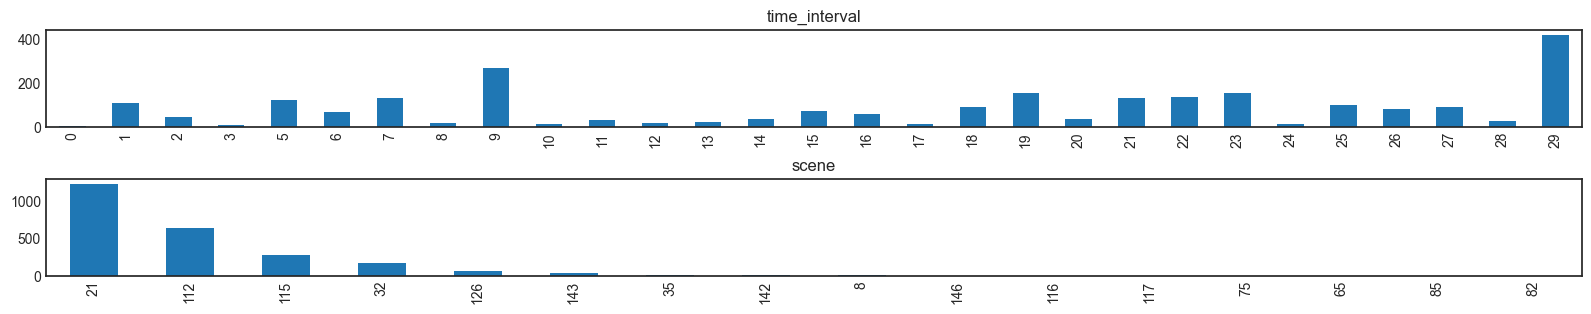

In [134]:
z_score_outliers = z_score_outlier_detection(all_df)
show_outlier_properties(z_score_outliers, ('time_interval', 'scene'))

In [136]:
all_df['is_outlier'] = False
all_df.loc[z_score_outliers.index, 'is_outlier'] = True

## Classification
### How to detect cloudy images without %?

In [137]:
LIMIT = 0.1
df['is_cloudy'] = df['cloud_percentage'] > LIMIT
all_df['is_cloudy'] = all_df['cloud_percentage'] > LIMIT
patch_df['is_cloudy'] = patch_df['cloud_percentage'] > LIMIT

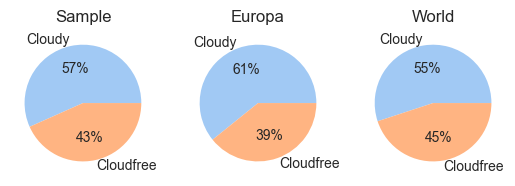

In [138]:
fig, axs = plt.subplots(1, 3)
for ax, df_, title in zip(axs, [patch_df, df, all_df], ["Sample", "Europa", "World"]):
    colors = sns.color_palette('pastel')[0:5]
    ax.pie(df_['is_cloudy'].value_counts(), labels=['Cloudy', 'Cloudfree'], colors=colors, autopct='%.0f%%')
    ax.set_title(title)

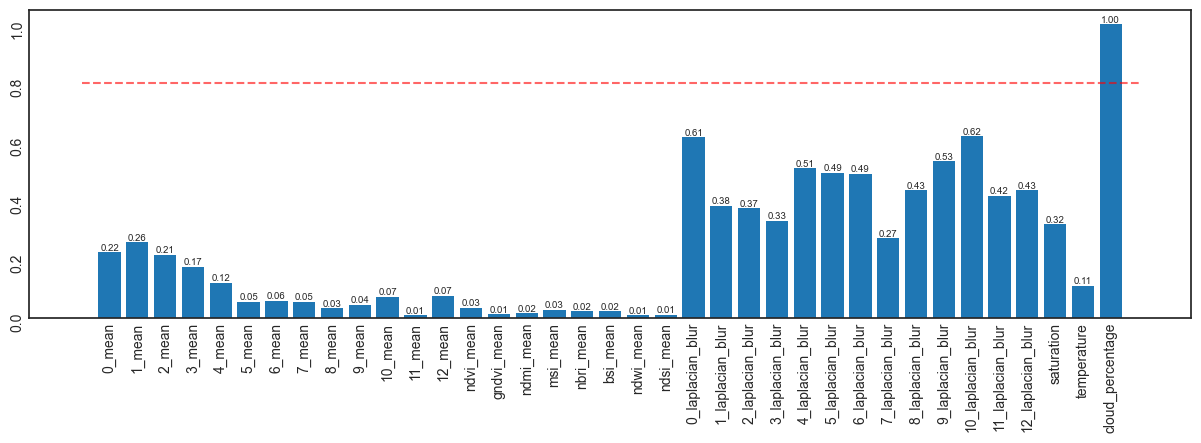

In [139]:
CORR_FEATS = OUTLIER_FEATS + [f"{i}_laplacian_blur" for i in range(13)] + ['saturation', 'temperature', 'cloud_percentage']
def show_corr_from(df, feat, ax=None, show_perc=False):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(15, 4))
    corrs = df[CORR_FEATS].corr()[feat].abs()
    p = ax.bar(corrs.index, corrs.values)
    ax.tick_params(rotation=90)
    #p = corrs.plot(kind='bar', ax=ax)
    if show_perc:
        ax.bar_label(p, label_type='edge', fmt="{:.2f}", fontsize="x-small")
    ax.plot([-1, len(CORR_FEATS)], [0.8, 0.8], '--r', alpha=0.6)
    return corrs
corrs_all_df = show_corr_from(all_df, 'cloud_percentage', show_perc=True)

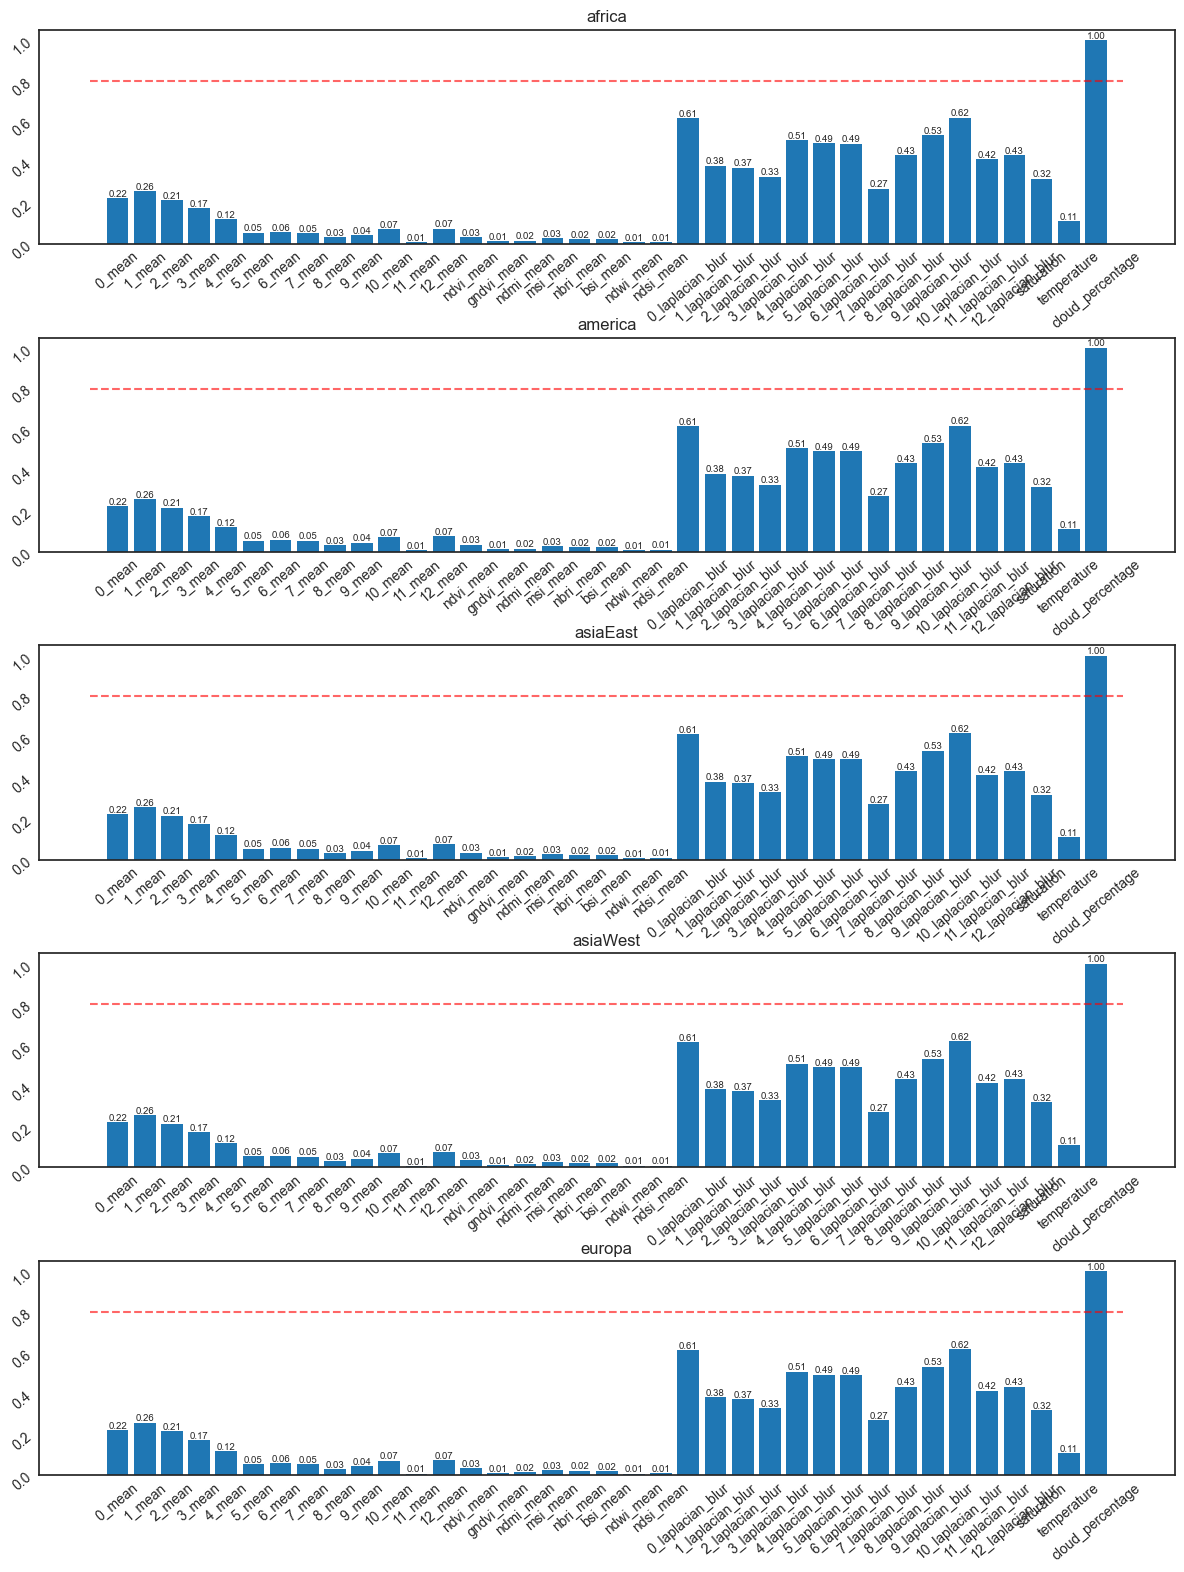

In [140]:
continents = all_df['continent'].unique()
fig, axs = plt.subplots(len(continents), 1, figsize=(12, len(continents) * 3))
fig.tight_layout(h_pad=5)
for ax, continent in zip(axs, continents):
    show_corr_from(all_df, 'cloud_percentage', ax=ax, show_perc=True)
    ax.set_title(continent)
    ax.tick_params(rotation=40)

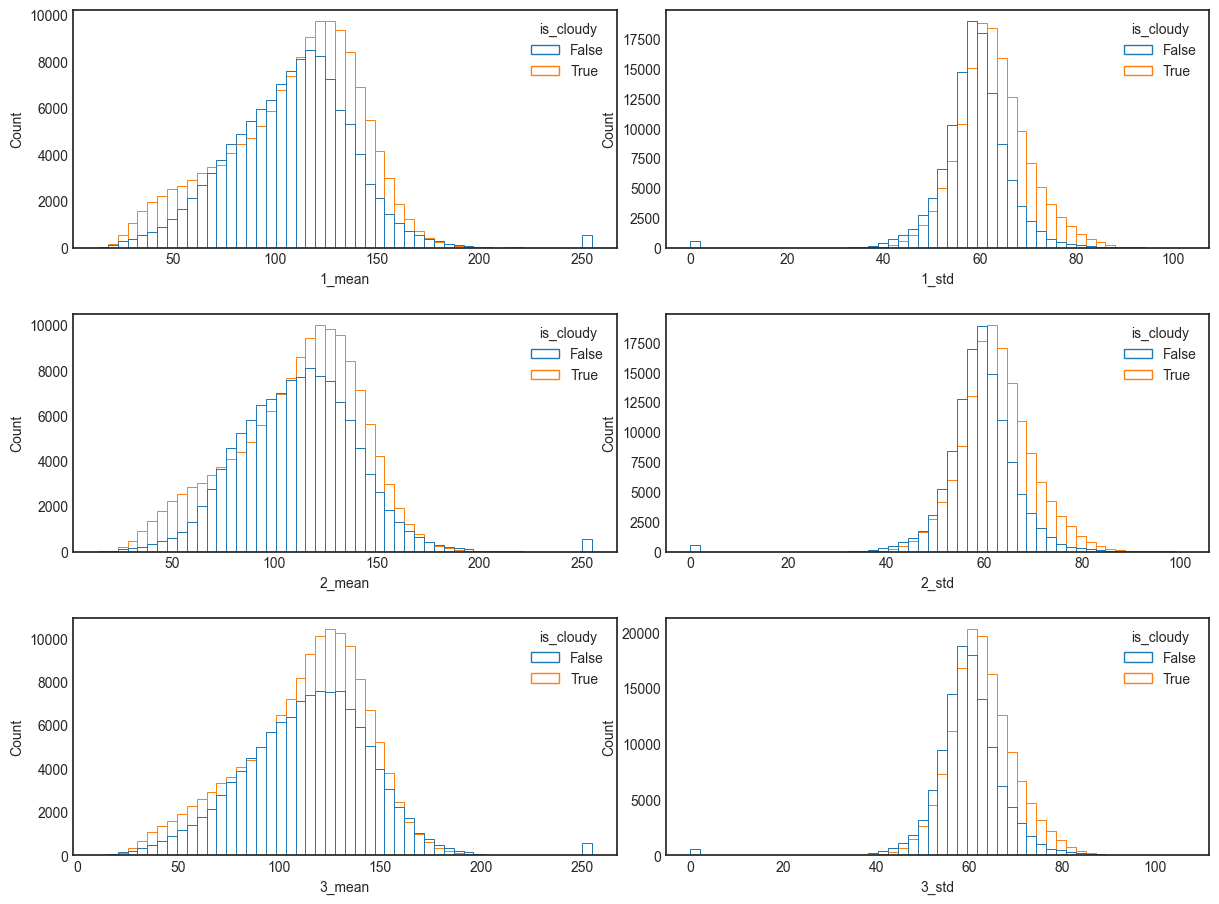

In [141]:
VISIBLE_BANDS = [[f"{i}_{value}" for value in ["mean", "std"]] for i in [1,2,3]]
fig, axs = plt.subplots(len(VISIBLE_BANDS), 2, figsize=(12, 3 * len(VISIBLE_BANDS)))
fig.tight_layout(h_pad=3)
for (mean_value, std_value), (mean_ax, std_ax) in zip(VISIBLE_BANDS, axs):
    sns.histplot(data=all_df, x=mean_value, hue='is_cloudy', bins=50, ax=mean_ax, fill=False)
    sns.histplot(data=all_df, x=std_value, hue='is_cloudy', bins=50, ax=std_ax, fill=False)


In [109]:
all_df[all_df['1_mean'] > 250]

0_traditional_contrast  0_michelson_contrast  0_rms_contrast  \
0                       0.0                   0.0             0.0   
1                       0.0                   0.0             0.0   
2                       0.0                   0.0             0.0   
3                       0.0                   0.0             0.0   
4                       0.0                   0.0             0.0   
..                      ...                   ...             ...   
280                     0.0                   0.0             0.0   
281                     0.0                   0.0             0.0   
282                     0.0                   0.0             0.0   
283                     0.0                   0.0             0.0   
284                     0.0                   0.0             0.0   

     0_laplacian_blur  0_mean  0_median  0_p25  0_p75  0_std  \
0                 0.0   255.0     255.0  255.0  255.0    0.0   
1                 0.0   255.0     255.0  255.0  255.0    0.0   
2                 0.0   255.0     255.0  255.0  255.0    0.0   
3                 0.0   255.0     255.0  255.0  255.0    0.0   
4                 0.0   255.0     255.0  255.0  255.0    0.0   
..                ...     ...       ...    ...    ...    ...   
280               0.0   255.0     255.0  255.0  255.0    0.0   
281               0.0   255.0     255.0  255.0  255.0    0.0   
282               0.0   255.0     255.0  255.0  255.0    0.0   
283               0.0   255.0     255.0  255.0  255.0    0.0   
284               0.0   255.0     255.0  255.0  255.0    0.0   

     1_traditional_contrast  ...  ndsi_p75  ndsi_over75       roi  season  \
0                       0.0  ...       0.0          0.0  ROIs1970  spring   
1                       0.0  ...       0.0          0.0  ROIs1970  spring   
2                       0.0  ...       0.0          0.0  ROIs1970  spring   
3                       0.0  ...       0.0          0.0  ROIs1970  spring   
4                       0.0  ...       0.0          0.0  ROIs1970  spring   
..                      ...  ...       ...          ...       ...     ...   
280                     0.0  ...       0.0          0.0  ROIs2017  winter   
281                     0.0  ...       0.0          0.0  ROIs2017  winter   
282                     0.0  ...       0.0          0.0  ROIs2017  winter   
283                     0.0  ...       0.0          0.0  ROIs2017  winter   
284                     0.0  ...       0.0          0.0  ROIs2017  winter   

     patch  scene  time_interval       time  continent  is_cloudy  
0      252    112              9 2018-04-26   asiaWest      False  
1       24    112              9 2018-04-26   asiaWest      False  
2       11    112              9 2018-04-26   asiaWest      False  
3      256    112              9 2018-04-26   asiaWest      False  
4      191    112              9 2018-04-26   asiaWest      False  
..     ...    ...            ...        ...        ...        ...  
280    259    115             29 2018-12-25   asiaWest      False  
281      1    115             29 2018-12-25   asiaWest      False  
282    140    115             29 2018-12-25   asiaWest      False  
283    170    115             29 2018-12-25   asiaWest      False  
284    100    115             29 2018-12-25   asiaWest      False  

[555 rows x 212 columns]